In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Dense 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from xmlrpc.client import MAXINT
import yfinance as yf

In [95]:
data = yf.download("INTC",period='6mo',interval='1h')
print(len(data))

[*********************100%***********************]  1 of 1 completed
869


In [96]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
2021-12-22 09:30:00-05:00,50.639999,50.680000,50.209999,50.509998,50.509998,3461086
2021-12-22 10:30:00-05:00,50.514999,50.834999,50.459999,50.790001,50.790001,2242704
2021-12-22 11:30:00-05:00,50.799999,50.919998,50.730000,50.802700,50.802700,1710248
2021-12-22 12:30:00-05:00,50.805000,50.915001,50.702099,50.770000,50.770000,1700220
2021-12-22 13:30:00-05:00,50.779999,50.830002,50.654999,50.692799,50.692799,1215270


In [97]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
2022-06-21 12:30:00-04:00,37.746498,37.830002,37.709999,37.740002,37.740002,1988913
2022-06-21 13:30:00-04:00,37.740002,37.820000,37.650002,37.772400,37.772400,2223710
2022-06-21 14:30:00-04:00,37.779999,37.886700,37.680000,37.779999,37.779999,5066715
2022-06-21 15:30:00-04:00,37.779999,37.840000,37.680000,37.709999,37.709999,4226379
2022-06-21 16:00:00-04:00,37.730000,37.730000,37.730000,37.730000,37.730000,0


In [98]:
close = data['Close']

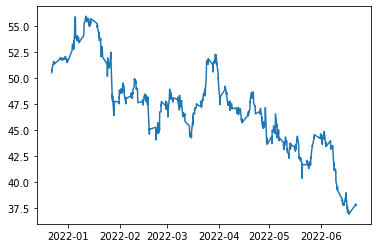

In [99]:
plt.plot(close)

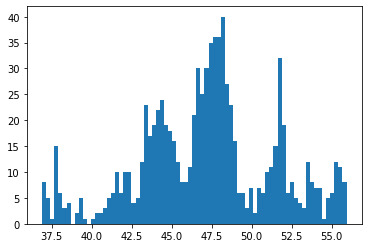

In [102]:
n, bins, p = plt.hist(close,bins=75)

<BarContainer object of 50 artists>

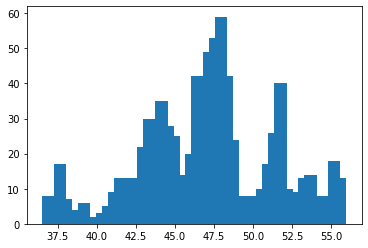

In [115]:
counts, edges = np.histogram(close, bins=50)
plt.bar(edges[:-1], counts)


In [117]:
peaks = find_peaks(counts)[0]
len(peaks)

9

In [89]:
def get_x_locs_minimal(data):
    counts, edges = np.histogram(data, bins=50)
    peaks = find_peaks(counts)[0]
    x_locs = []
    for j in peaks:
        x_locs.append(edges[j])
    return x_locs

In [22]:
def interpolate(x, map_vals):
    """
    Method to map values of x to their closest value in the map values list 

    Parameters: 
        - x: list or array like iterable that is to be mapped
        - map_vals: list or array like iterable that serves as the mapping for X

    Returns: 
        - new_data: numpy array 
    """
    new_data = []
    # for each number in x
    for num in x:
        min_dist = MAXINT
        val = num
        for i in map_vals:
            dist = abs(num - i)
            if dist < min_dist:
                min_dist = dist
                val = i
        new_data.append(val)

    return np.asarray(new_data)

In [23]:
def find_closest_val(element, arr):
    """
    Method to find the closest element in arr to the element passed in 

    Parameters: 
        - element: int
        - arr: unique values
    Returns: 
        - idx: int, index of the closest value
    """
    min_diff = 1000000
    idx = -1
    for number in arr:
        diff = abs(element - number)
        if diff < min_diff:
            min_diff = diff
            idx = arr.index(number)

    return idx

In [24]:
def transform_list(arr, unique_vals):
    """
     Method to transform the list from high values to indicies of where those occur in the uniques values array 
     Parameters: 
        - arr: array or list like iterable 
        - unique_vals: array or list like iterable that contains all the unique values of arr
    Return: 
        - arr/list
"""
    new_list = []
    for elm in arr:
        if elm not in unique_vals:
            tmp = unique_vals[find_closest_val(elm, unique_vals)]
            new_list.append(tmp)
        else:
            new_list.append(np.where(unique_vals == elm))
    new_list = np.asarray(new_list)
    new_list = new_list.reshape(-1)
    return new_list

In [25]:
def preprocess_data_classification(corrupted, wsz, scaler, x_locs):
    """
    Method to preprocess the data for classification models
    Parameters: 
        - pri_data: numpy array array of pri_data
        - wsz: int, window size
        - scaler: Scaler object, example: StandardScaler, MinMaxScaler

    Returns 
        - x_train, x_test, y_train, y_test: arrays or list like iterables of all the data
    """
    interp_data = interpolate(corrupted, x_locs)
    transformed_1 = transform_list(interp_data, list(x_locs))
    y_list = []
    for i in range(len(transformed_1) - (wsz)):
        y_list.append(transformed_1[i+wsz])
    y_data_cat = to_categorical(y_list, num_classes=len(x_locs))
    y_data = np.asarray(y_data_cat)
    corrupted = corrupted.reshape(-1, 1)
    # Fit and transform to the scaler object
    scaler.fit(corrupted)
    corrupted = scaler.transform(corrupted)
    # list to hold x_data
    x_data = []
    # Slide window over data and save the window as X and the next PRI as Y
    for i in range(len(corrupted)-(wsz)):
        x_data.append(corrupted[i:i+wsz])
    x_data = np.asarray(x_data)
    # fix x data structure
    x_data = x_data.reshape(-1, wsz)

    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, train_size=0.3, random_state=42)
    return x_train, x_test, y_train, y_test

In [90]:
xlocs = get_x_locs_minimal(close)


In [91]:
len(xlocs)

25

In [82]:
close = np.asarray(close)

In [83]:
xtrain, xtest, ytrain, ytest = preprocess_data_classification(close,7,StandardScaler(), xlocs)

IndexError: list index out of range

In [52]:
len(xtrain)

300

In [50]:
xval = xtrain[-10:]
yval = ytrain[-10:]

xtrain = xtrain[:-10]
ytrain = ytrain[:-10]

In [51]:
model = Sequential()
model.add(Dense(7,activation='relu', input_shape=(7,)))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(len(xlocs),activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

In [53]:
hist = model.fit(xtrain,ytrain,epochs=100)

Epoch 1/100
10/10 [==============================] - 1s 1ms/step - loss: 0.9784 - accuracy: 0.7267
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.8858 - accuracy: 0.7933
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 0.8123 - accuracy: 0.8033
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.7438 - accuracy: 0.8567
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.8933
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: 0.6169 - accuracy: 0.9300
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5500 - accuracy: 0.9433
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.9600
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.9700
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 0.3877 - accuracy: 0.9667
Epoch 11/

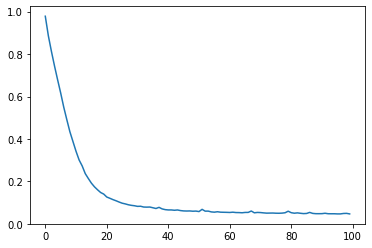

In [54]:
plt.plot(hist.history["loss"])

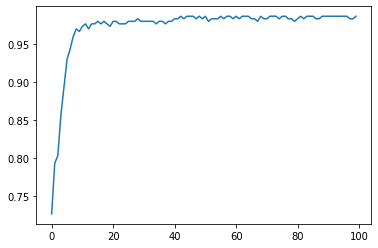

In [55]:
plt.plot(hist.history["accuracy"])

In [56]:
def adjust_answers(answers):
    """
    Method to take the answer vecotrs and make the elements either 0's or 1's. This is because the output of the ML 
    model is decimals and can be very small but not zero.
    Parameters: 
        - answers: array or list like iterable of all answer vectors. 
    Returns: 
        - adjusted: array or list like iterable of all the asnwer vectors transformed to have 0's and 1's
    """
    adjusted = []
    for ans in answers:
        # get max value and index of it for each array
        tmp = []
        m_val = np.amax(ans)
        for elm in ans:
            if elm != m_val:
                tmp.append(0)
            else:
                tmp.append(1)
        adjusted.append(tmp)
    adjusted = np.asarray(adjusted)
    return adjusted

In [57]:
def inverse_transform_list(ans_arr, unique_val_arry):
    """
    Method to take the inverse transform of an answer array
    Parameters: 
        - ans_arry: array or list like iterable of the answers that the ML model predicted
        - unique_val_array: array or list like iterable of all unique values that the ans can possible be 
    Returns:
        - real_value_answer: array or list like iterable of the answers
"""
    transformed_list = []
    for elm in ans_arr:
        idx = np.where(elm == 1)
        transformed_list.append(unique_val_arry[idx[0][0]])
    return transformed_list

In [58]:
preds = model.predict(xval)
preds = adjust_answers(preds)
preds = inverse_transform_list(preds, xlocs)

In [60]:
yval = inverse_transform_list(yval, xlocs)

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
mean_squared_error(yval, preds)

0.0